## here we forst want to combine the tensors of image and text 
## let see how we can do that..

In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
import numpy as np
import pandas as pd
import transformers

<class 'PIL.JpegImagePlugin.JpegImageFile'>


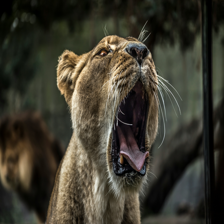

In [8]:
### lets import an image 

image_size = 224

image = Image.open("test_images/samuel-scrimshaw-KeUKM5N-e_g-unsplash.jpg")
print(type(image))

image = image.convert("RGB")

## apply resize

image = image.resize((image_size,image_size), resample=Image.Resampling.BICUBIC)
image

In [9]:
## rescale 

image_np = np.array(image)/255.0
image_np.shape

(224, 224, 3)

In [10]:
image_np.dtype

dtype('float64')

In [11]:
image_mean = [0.5,0.5,0.5]
image_std =  [0.5,0.5,0.5]

normalized_image = (image_np - image_mean)/image_std

normalized_image

array([[[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-0.85882353, -0.88235294, -0.95294118],
        [-0.86666667, -0.88235294, -0.96078431],
        [-0.8745098 , -0.88235294, -0.94509804]],

       [[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-0.89803922, -0.90588235, -0.96862745],
        [-0.90588235, -0.90588235, -0.96078431],
        [-0.88235294, -0.89803922, -0.95294118]],

       [[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-0.89019608, -0.89019608, -0.9372549 ],
        [-0.88235294, -0.89019608, -0.92941176],
        [-0.8745098 , -0.88235294, -0.92156863]],

       ...,

       [[-0.80392157, -0.75686275, -0.81176471],
        [-0

In [12]:
normalized_image.shape

(224, 224, 3)

In [14]:
## lets correct the channel

image_tensor = torch.Tensor(normalized_image.transpose(2,0,1)).unsqueeze(0)

## we can see the bacth Dimensions also
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [16]:
## lets create one text prompt 

prompt = "What is shown in the image?"
bos_token = "<s>"
image_token = "<image>"
num_image_sequence = 32

prompt_with_image = f"{image_token*num_image_sequence}{bos_token}{prompt}\n"

print("Final Prompt : \n ",prompt_with_image)

Final Prompt : 
  <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><s>What is shown in the image?



In [17]:
## lets take one tokenizer 
from transformers import AutoTokenizer

In [18]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [22]:
tokenizer.add_special_tokens({
    "additional_special_tokens" : [image_token],
})

tokenizer.add_bos_token = False
tokenizer.add_eos_token = False

inputs = tokenizer(prompt_with_image, return_tensors="pt")

print(inputs)

{'input_ids': tensor([[  101, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522,  1026,  1055,  1028,  2054,  2003,  3491,  1999,
          1996,  3746,  1029,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [23]:
print(inputs["input_ids"])

tensor([[  101, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522, 30522,
         30522, 30522, 30522,  1026,  1055,  1028,  2054,  2003,  3491,  1999,
          1996,  3746,  1029,   102]])


In [24]:
print(inputs["input_ids"].shape)

torch.Size([1, 44])


## Now Try to Understand the Actual Code 

In [ ]:
import numpy as np
from PIL import Image
import os
import torch 
from typing import List, Dict, Optional, Tuple, Union, Iterable


IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]


def add_image_tokens_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"


def resize(image, size, resample = None, reducing_gap= None ):
    height, width = size[0], size[1]

    resized_image = image.resize((width, height), resample=resample)
    
    return resized_image


def rescale(image, scale, dtype=np.float32):

    rescaled_image = image*scale

    rescaled_image = rescaled_image.astype(dtype)

    return rescaled_image

def normalize(image, mean, std):
    mean = np.array(mean, dtype = image.dtype)
    std = np.array(std, dtype = image.dtype)

    image = (image - mean)/std

    return image



def process_images(images, size, resample, rescale_factor, image_mean, image_std):
    height, width = size[0], size[1]

    images = [resize(image=image, size=(height, width),resample=resample) for image in images]

    images = [np.array(image) for image in images]

    images = [rescale(image, scale= rescale_factor) for image in images]

    images = [normalize(image, mean = image_mean, std = image_std) for image in images]

    images = [image.transpose(2,0,1) for image in images]

    return images


class PaliGemmaProcessor:
    IMAGE_TOKEN = "<image>"

    def __init__(self, tokenizer, num_image_tokens, image_size):

        super().__init__()

        self.image_seq_length = num_image_tokens
        self.image_size = image_size

        ## additional token added to the tokenizer
        token_to_add = {"additional_special_tokens": [self.IMAGE_TOKEN]}

        tokenizer.add_special_tokens(token_to_add)

        ## Extra token for the image

        EXTRA_TOKENS = [
            f"<loc{i:04d}>" for i in range(1024)
        ] ## these tokens are used for object detection (bounding boxes)

        EXTRA_TOKENS += [
            f"<seg{i:03d}>" for i in range(128)
        ] ## these tokens are used for segmentation

        tokenizer.add_tokens(EXTRA_TOKENS)
        self.image_token_id = tokenizer.convert_tokens_to_ids(self.IMAGE_TOKEN)

        ## we will add the bos and eos token ourselves

        tokenizer.add_bos_token = False
        tokenizer.add_eos_token = False

        self.tokenizer = tokenizer

    def __call__(self, text, images, padding ="longest", truncation = True):
        assert len(images) == 1 and len(text) == 1,f"Received {len(images)} images for {len(text)} prompts."

        pixel_values = process_images(
            images,
            size = (self.image_size, self.image_size),
            resample = Image.Resampling.BICUBIC,
            rescale_factor = 1 / 255.0,
            image_mean = IMAGENET_STANDARD_MEAN,
            image_std = IMAGENET_STANDARD_STD 
        )

        pixel_values = np.stack(pixel_values, axis=0)
        pixel_values = torch.tensor(pixel_values)

        ## Prepend a self.image_seq_length number of image tokens to the prompt

        input_string = [
            add_image_tokens_prompt(
                prefix_prompt = prompt,
                bos_token = self.tokenizer.bos_token,
                image_seq_len = self.image_seq_length,
                image_token = self.IMAGE_TOKEN
            )
            for prompt in text
        ]


        ## return the input_ids and attention_mask as pytorch tensors

        inputs = self.tokenizer(
            input_string,
            return_tensors = "pt",
            padding = padding,
            truncation = truncation
        )

        return_data = {"pixel_values":pixel_values, **inputs}

        return return_data